# Inflation Model

## Packages

In [1]:
# install.packages('ggplot2')
# install.packages('scales')
# install.packages('ggfortify')

In [2]:
library(TSA)
library(ggplot2)
library(ggfortify)
library(scales)

theme_set(theme_bw())


Attaching package: 'TSA'


The following objects are masked from 'package:stats':

    acf, arima


The following object is masked from 'package:utils':

    tar




## Data

In [3]:
# function to convert string date to year month vector
year_mon <- function(string_date){
  year <- as.integer(substr(string_date, start = 1, stop = 4))
  mon <- as.integer(substr(string_date, start = 6, stop = 7))
  return(c(year, mon))
}

In [4]:
raw.intdata <- read.csv("IRLTLT01ZAM156N.csv")
raw.infldata <- read.csv("ZAFCPIALLMINMEI.csv")
bond_term <- 10

start_date <- "2010-01-01"
end_date <- "2019-12-01"
start_index_int <- which(raw.intdata$DATE==start_date)
end_index_int <- which(raw.intdata$DATE==end_date)
start_index_infl <- which(raw.infldata$DATE==start_date)
end_index_infl <- which(raw.infldata$DATE==end_date)

int_data <- matrix(c(raw.intdata[start_index_int:end_index_int, "IRLTLT01ZAM156N"], 
                     rep(bond_term, length(start_index_int:end_index_int))), ncol=2)

# monthly effective interest rates
int_series <- ts((1+int_data[, 1]/100)^(1/12)-1, 
                 start = year_mon(start_date), frequency=12)

# monthly effective inflation
infl_data <- c(raw.infldata$ZAFCPIALLMINMEI[-1]/
                 raw.infldata$ZAFCPIALLMINMEI[-nrow(raw.infldata)])-1

infl_series <- ts(infl_data[start_index_infl:end_index_infl], 
                  start = year_mon(start_date), frequency=12)

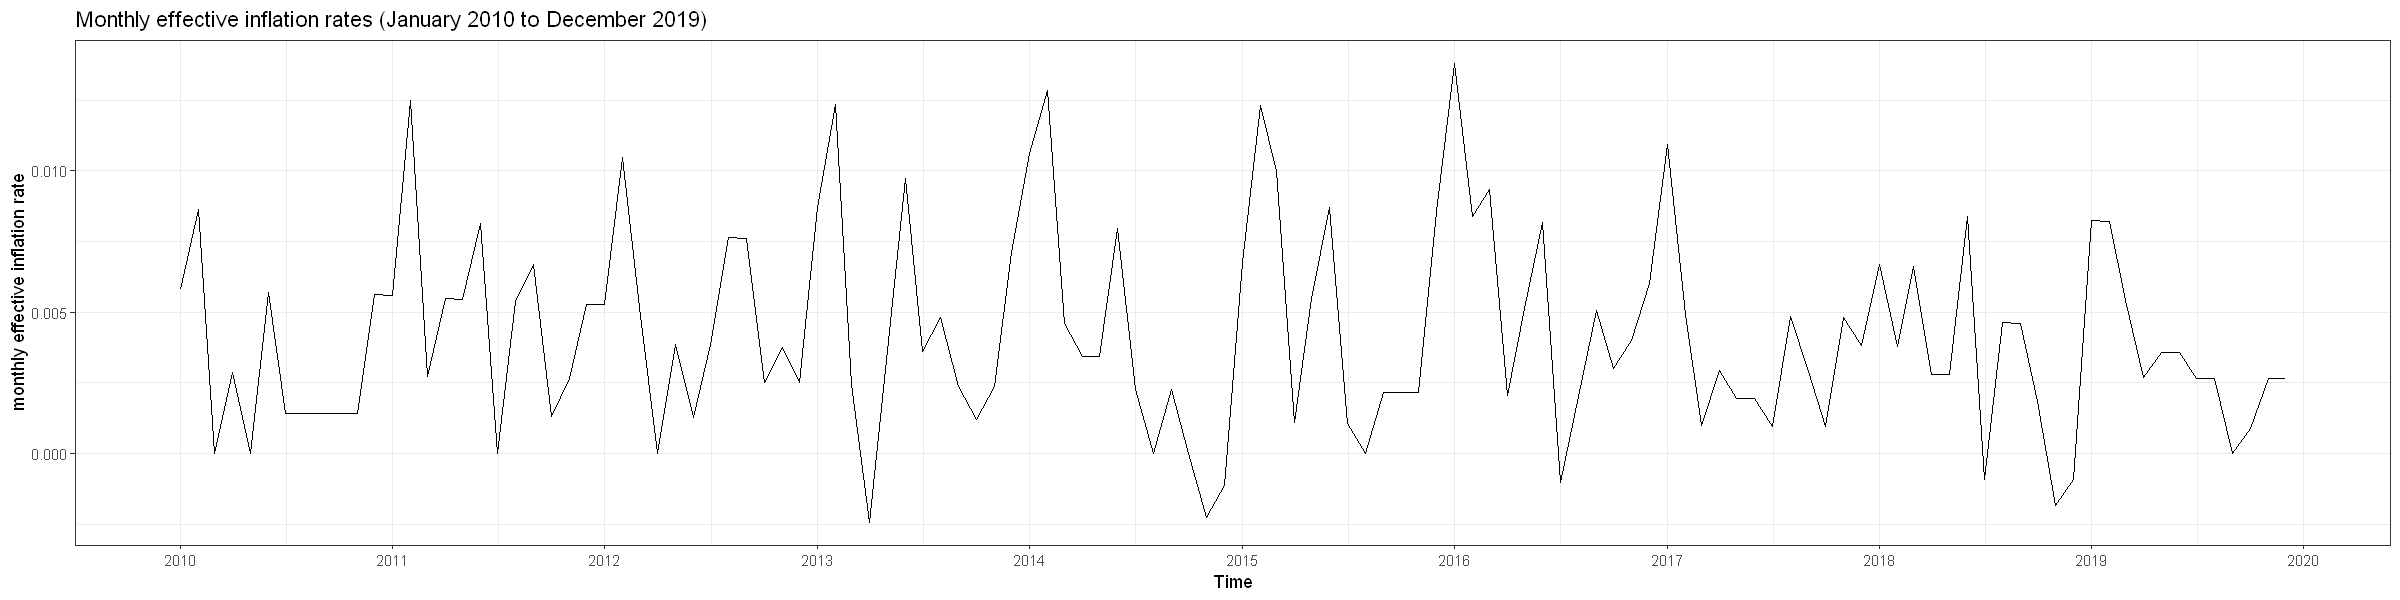

In [5]:
options(repr.plot.width=20, repr.plot.height=5)

(infl_plot <- autoplot(infl_series)+
  ggtitle("Monthly effective inflation rates (January 2010 to December 2019)") +
  ylab("monthly effective inflation rate") +
  xlab("Time") +
  scale_x_date(breaks = breaks_pretty(10)))

In [6]:
create_lagged_dataframe <- function(int_series, infl_series, int_lags, infl_lags){
  n <- length(int_series)
  max_lag <- max(c(int_lags, infl_lags))
  ncols <- length(int_lags) + length(infl_lags)
  nrows <- length(int_series) - max_lag
  datfram <- as.data.frame(matrix(nrow=nrows, ncol=ncols))
  
  k = 0
  for (i in infl_lags){
    datfram[, k+1] <- infl_series[(max_lag-i+1):(n-i)]
    colnames(datfram)[k+1] <- paste0("infl.l", as.character(i))
    k <- k + 1
  }
  
  for (i in int_lags){
    datfram[, k+1] <- int_series[(max_lag-i+1):(n-i)]
    colnames(datfram)[k+1] <- paste0("int.l", as.character(i))
    k <- k + 1
  }
  
  return(datfram)
}

## Model

### Fit Linear Regression

In [7]:
lagged_datfram <- create_lagged_dataframe(int_series, infl_series, c(0:1), c(0:1))
lagged_datfram_interact <- as.data.frame(model.matrix(~-1 + ., lagged_datfram))

reg_model <- lm(infl.l0 ~ -1 + ., data = lagged_datfram_interact)
summary(reg_model)


Call:
lm(formula = infl.l0 ~ -1 + ., data = lagged_datfram_interact)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0058332 -0.0023030 -0.0004531  0.0023509  0.0074865 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)   
infl.l1  0.28748    0.08694   3.307  0.00126 **
int.l0   4.27180    1.57703   2.709  0.00778 **
int.l1  -3.84328    1.57740  -2.436  0.01635 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.00331 on 116 degrees of freedom
Multiple R-squared:  0.637,	Adjusted R-squared:  0.6276 
F-statistic: 67.85 on 3 and 116 DF,  p-value: < 2.2e-16


### Fit ARIMA model on regression errors

In [8]:
arima_model <- arima(reg_model$residuals, seasonal = list(order=c(1, 0, 1), period=12), include.mean = FALSE)
arima_model


Call:
arima(x = reg_model$residuals, seasonal = list(order = c(1, 0, 1), period = 12), 
    include.mean = FALSE)

Coefficients:
        sar1     sma1
      0.8904  -0.5390
s.e.  0.0706   0.1463

sigma^2 estimated as 6.45e-06:  log likelihood = 538.6,  aic = -1073.2

### Residual Analysis

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



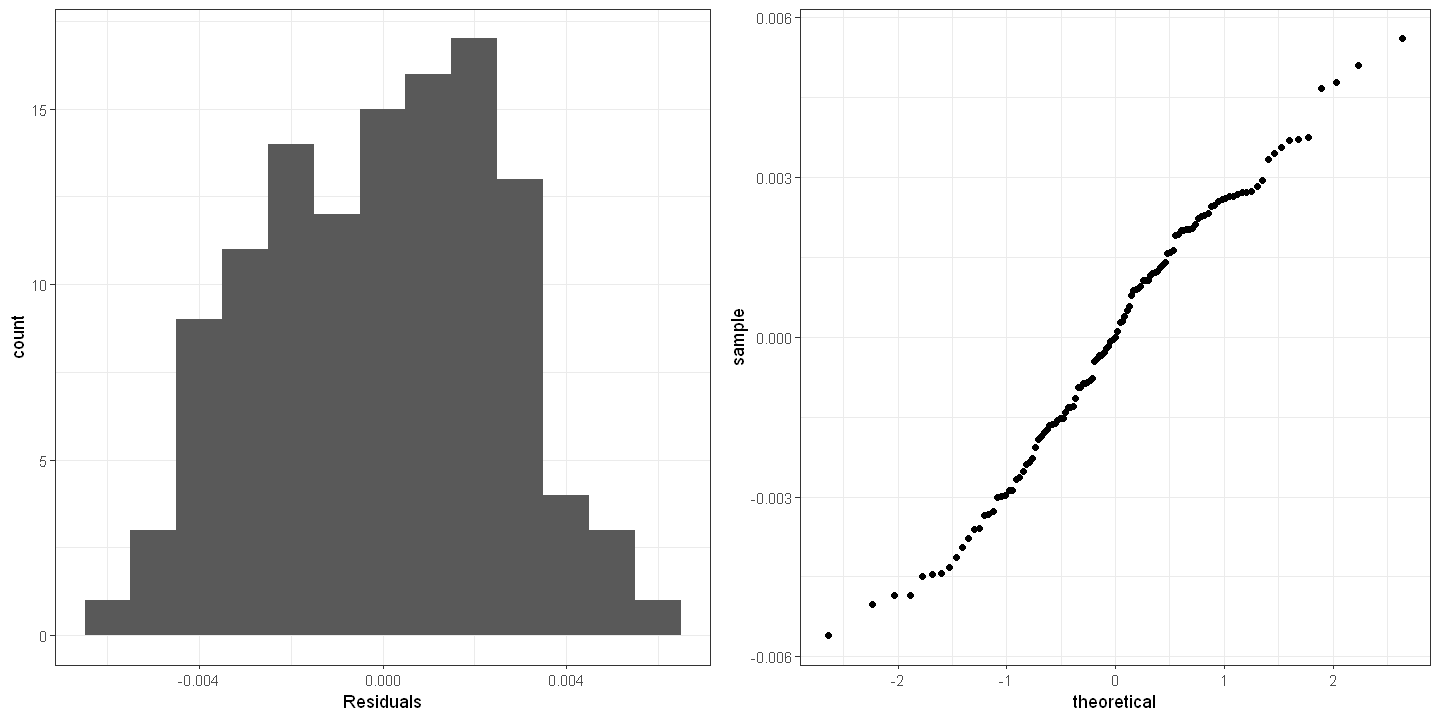

In [9]:
options(repr.plot.width=12, repr.plot.height=6)
#plot(residuals(infl_model), type="l")

res_hist <- ggplot() + geom_histogram(aes(residuals(arima_model)), binwidth = 0.001) +
            xlab("Residuals")
res_qqnorm <- ggplot() + stat_qq(aes(sample=residuals(arima_model)))

gridExtra::grid.arrange(res_hist, res_qqnorm, ncol=2, nrow=1)

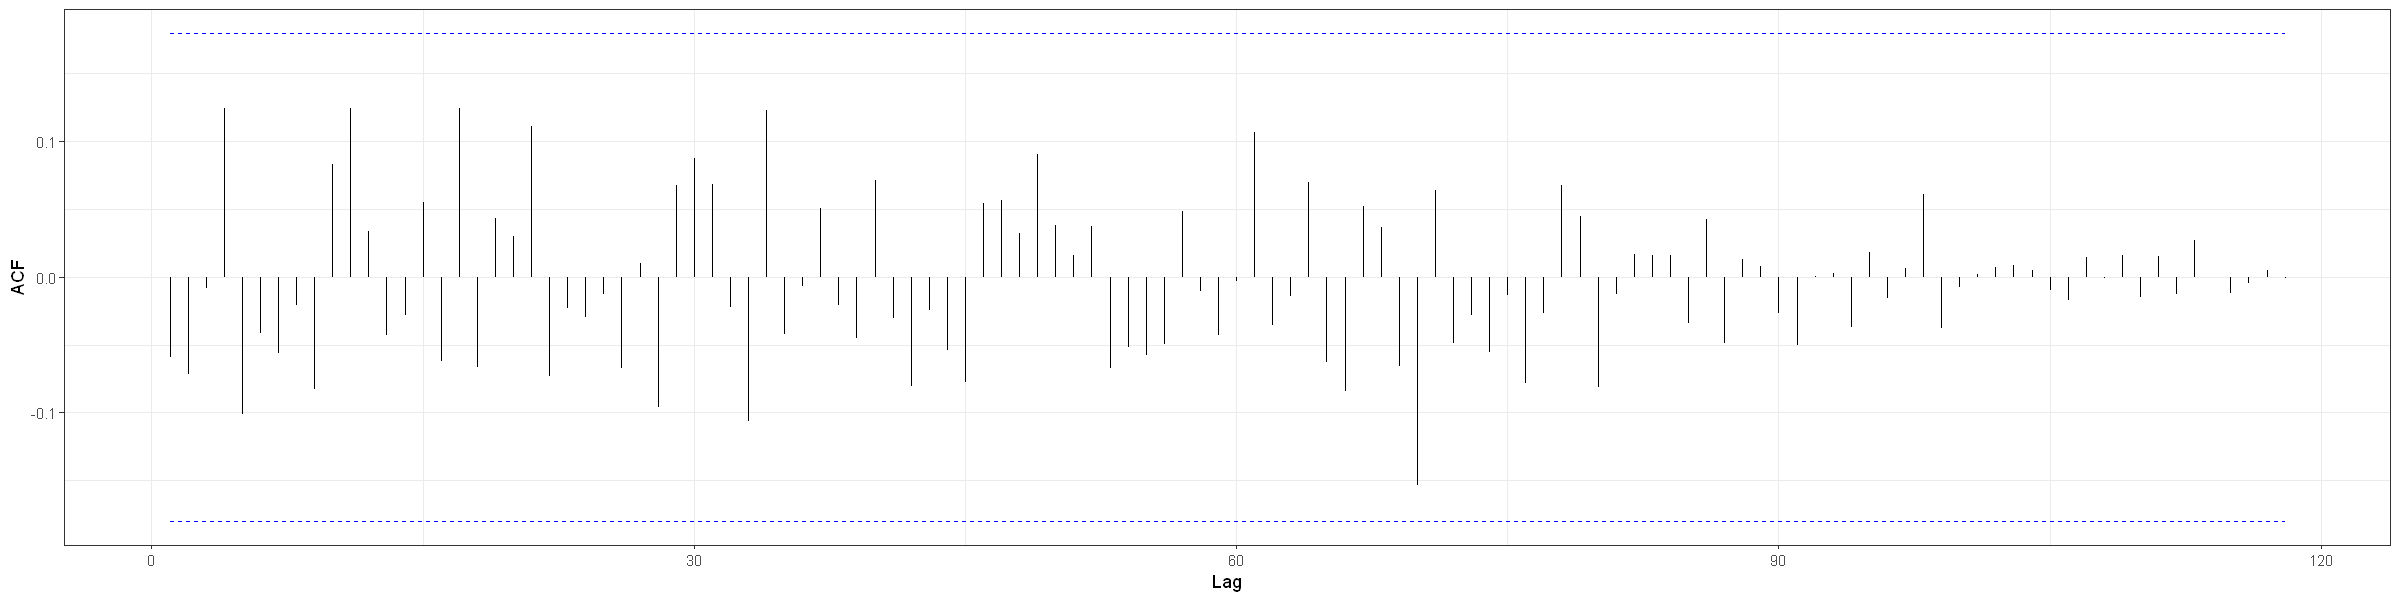

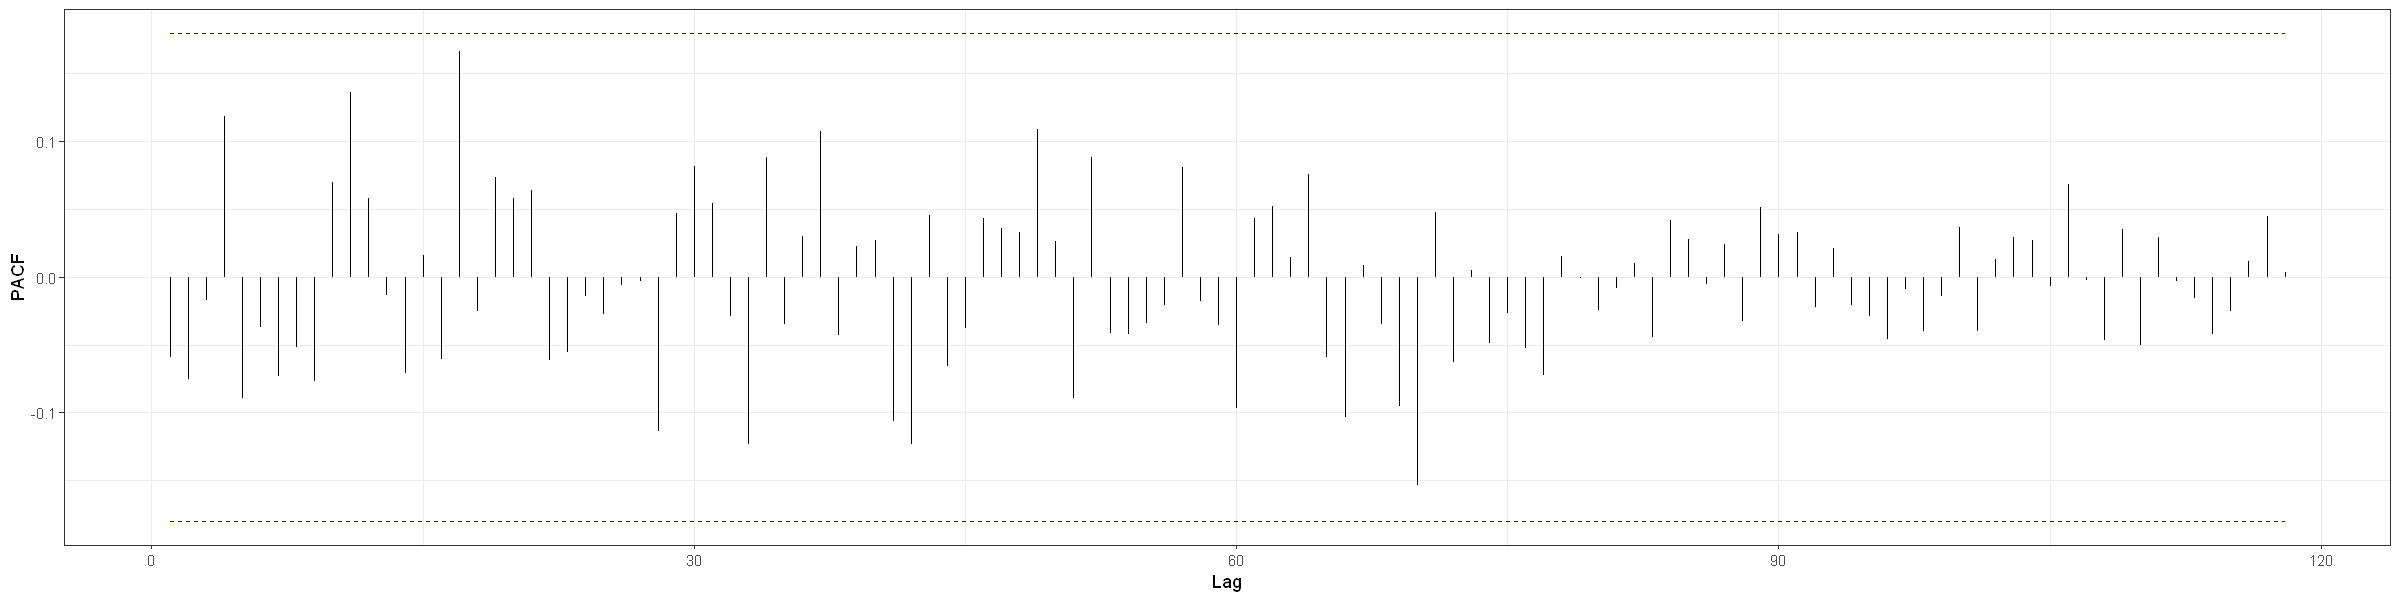

In [10]:
options(repr.plot.width=20, repr.plot.height=5)
autoplot(acf(residuals(arima_model), lag.max = 200, plot=FALSE))
autoplot(pacf(residuals(arima_model), lag.max = 200, plot=FALSE)) + ylab("PACF")

## Save Model

In [11]:
reg_errors <- reg_model$residuals
n <- length(reg_errors)
reg_errors <- as.numeric(reg_errors[(n-11):n])

arima_errors <- arima_model$residuals
m <- length(arima_errors)
arima_errors <- as.numeric(arima_errors[(m-11):m])

param = list("beta" = reg_model$coefficients, "reg_errors" = reg_errors, "Phi" = arima_model$coef["sar1"], "Theta" = arima_model$coef["sma1"], "sigma" = sqrt(arima_model$sigma2), "arima_errors" = arima_errors, "end_value" = infl_series[length(infl_series)])

# save(param, file = "inflation_param.RData")